# 나중에 시도해볼 블로그

https://deep-learning-study.tistory.com/134

In [2]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [7]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/박성준배경1.jpg'  # 인물 추출로 쓸 사진입니다!
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/배경.jpg'  # 배경으로 쓸 사진입니다! 
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(1110, 1700, 3)
(1110, 1700, 3)


In [11]:
# 세그멘테이션 모델을 만들어봅시다.

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [13]:
# 사전에 학습된 가중치를 불러옵니다

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [17]:
# 준비한 이미지를 네트워크에 입력합니다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1110, 1700, 3) (334, 513, 3) 15


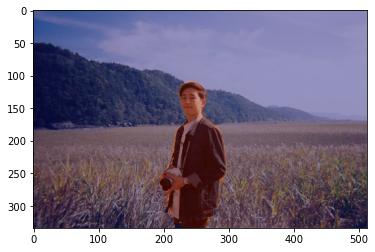

In [18]:
# 사람만 추출해봅시다! == 라벨이 15인 것만 추출해봅시다!!

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 고양고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

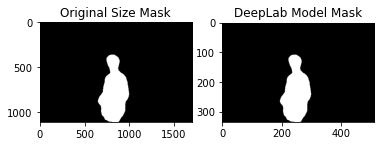

In [19]:
# resize 했던 이미지를 원래 크기로 만들어봅시다.
# 세그멘테이션 마스크를 원래 크기로!!

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # shape[:2][::-1]
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # 128을 바꾸면 고양이가 안잘려..

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

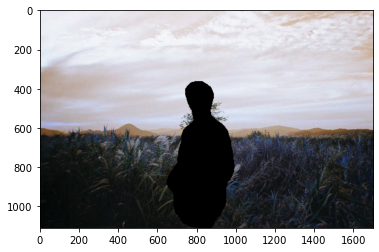

In [21]:
# 세그멘테이션 마스크를 이용해 배경만 추출해보자!!

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)


img_bg = cv2.bitwise_and(img_orig2, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [ ]:
# 블러처리는 생략합니다.

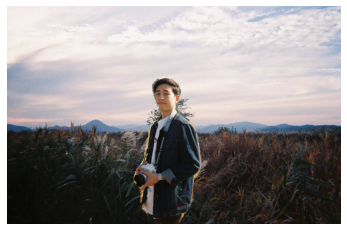

In [23]:
# 따로 빼두었던 마스크를 블러처리된 배경에 넣어보자

img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig("./human_segmentation/images/배경바꾸기.jpg")
plt.show()